In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from datetime import timedelta
import joblib

In [2]:
# Membaca dataset
df = pd.read_csv("../Dataset/dataset time series.csv")
print("Data awal:")
df.head()

Data awal:


,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,01-01-2020,24,29.6,26.3,88,23.5,3.4,6,280,2,C
1,02-01-2020,24.2,32.8,28.5,82,12.4,0.0,9,280,3,W
2,03-01-2020,25.8,32.0,28.2,82,0,8.3,12,300,5,NW
3,04-01-2020,26.2,31.6,28.3,82,0.4,5.8,8,300,5,W
4,05-01-2020,26.4,32.6,27.7,84,0.1,2.1,14,270,4,NW


In [3]:
print("\nInformasi data:")
df.info()


Informasi data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TANGGAL  1887 non-null   object 
 1   TN       1887 non-null   object 
 2   TX       1887 non-null   float64
 3   TAVG     1887 non-null   float64
 4   RH_AVG   1887 non-null   int64  
 5   RR       1887 non-null   object 
 6   SS       1887 non-null   float64
 7   FF_X     1887 non-null   int64  
 8   DDD_X    1887 non-null   int64  
 9   FF_AVG   1887 non-null   int64  
 10  DDD_CAR  1887 non-null   object 
dtypes: float64(3), int64(4), object(4)
memory usage: 162.3+ KB


In [4]:
print("\nStatistik deskriptif:")
df.describe()


Statistik deskriptif:


,TX,TAVG,RH_AVG,SS,FF_X,DDD_X,FF_AVG
count,1887.000000,1887.000000,1887.00000,1887.000000,1887.000000,1887.000000,1887.000000
mean,32.078908,28.469687,80.45257,6.660996,7.403286,185.336513,2.361420
std,1.269501,1.108534,6.80323,3.352550,2.437566,85.456051,1.222689
min,26.200000,24.300000,59.00000,0.000000,0.000000,0.000000,0.000000
25%,31.400000,27.700000,76.00000,4.000000,6.000000,120.000000,1.000000
50%,32.000000,28.400000,81.00000,7.900000,7.000000,150.000000,2.000000
75%,32.800000,29.200000,86.00000,9.700000,9.000000,280.000000,3.000000
max,35.800000,32.100000,98.00000,11.700000,19.000000,360.000000,7.000000


In [5]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(columns=["DDD_CAR", 'DDD_X'])

In [6]:
# Konversi semua kolom bertipe object ke numerik
for col in ["TN", "RR"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
# Ganti nilai 8888 dan 9999 dengan None (NaN)
df = df.replace({8888: np.nan, 9999: np.nan})

In [8]:
# Memeriksa nilai yang hilang
print("\nJumlah nilai yang hilang:")
df.isna().sum()


Jumlah nilai yang hilang:


TANGGAL      0
TN           1
TX           0
TAVG         0
RH_AVG       0
RR         127
SS           0
FF_X         0
FF_AVG       0
dtype: int64

In [9]:
# Menerapkan metode interpolasi untuk mengisi nilai yang hilang
df = df.interpolate(method='linear')

C:\Users\PC\AppData\Local\Temp\ipykernel_3452\3851919780.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


In [10]:
# Mengubah kolom 'TANGGAL' ke format datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'], format='%d-%m-%Y')

In [11]:
# Menambahkan Fitur Waktu yang lebih detail
df['Hari'] = df['TANGGAL'].dt.dayofweek  # 0-6 dimana 0=Senin
df['Bulan'] = df['TANGGAL'].dt.month     # 1-12
df['Tahun'] = df['TANGGAL'].dt.year      # Tahun
df['Hari_Bulan'] = df['TANGGAL'].dt.day  # 1-31
df['Kuartal'] = df['TANGGAL'].dt.quarter # 1-4
df['Hari_Tahun'] = df['TANGGAL'].dt.dayofyear # 1-365

In [12]:
# Menambahkan fitur lag untuk data time series
# Fitur lag penting untuk model time series karena menangkap pola historis
for col in ['TX', 'TAVG', 'RH_AVG', 'RR', 'SS']:
    df[f'{col}_lag1'] = df[col].shift(1)  # 1 hari sebelumnya
    df[f'{col}_lag7'] = df[col].shift(7)  # 1 minggu sebelumnya
    df[f'{col}_lag15'] = df[col].shift(15)  # 2 minggu sebelumnya
    df[f'{col}_lag30'] = df[col].shift(30)  # 1 bulan sebelumnya
    df[f'{col}_rolling3'] = df[col].rolling(window=3).mean()  # Rolling mean 3 hari
    df[f'{col}_rolling7'] = df[col].rolling(window=7).mean()  # Rolling mean 7 hari
    df[f'{col}_rolling15'] = df[col].rolling(window=15).mean() # Rolling mean 15 hari
    df[f'{col}_rolling30'] = df[col].rolling(window=30).mean() # Rolling mean 30 hari

In [13]:
df.isna().sum()

TANGGAL              0
TN                   0
TX                   0
TAVG                 0
RH_AVG               0
RR                   0
SS                   0
FF_X                 0
FF_AVG               0
Hari                 0
Bulan                0
Tahun                0
Hari_Bulan           0
Kuartal              0
Hari_Tahun           0
TX_lag1              1
TX_lag7              7
TX_lag15            15
TX_lag30            30
TX_rolling3          2
TX_rolling7          6
TX_rolling15        14
TX_rolling30        29
TAVG_lag1            1
TAVG_lag7            7
TAVG_lag15          15
TAVG_lag30          30
TAVG_rolling3        2
TAVG_rolling7        6
TAVG_rolling15      14
TAVG_rolling30      29
RH_AVG_lag1          1
RH_AVG_lag7          7
RH_AVG_lag15        15
RH_AVG_lag30        30
RH_AVG_rolling3      2
RH_AVG_rolling7      6
RH_AVG_rolling15    14
RH_AVG_rolling30    29
RR_lag1              1
RR_lag7              7
RR_lag15            15
RR_lag30            30
RR_rolling3

In [14]:
# Menghapus baris dengan nilai NaN (hasil dari operasi lag dan rolling)
df = df.dropna()

In [15]:
df.isna().sum()

TANGGAL             0
TN                  0
TX                  0
TAVG                0
RH_AVG              0
RR                  0
SS                  0
FF_X                0
FF_AVG              0
Hari                0
Bulan               0
Tahun               0
Hari_Bulan          0
Kuartal             0
Hari_Tahun          0
TX_lag1             0
TX_lag7             0
TX_lag15            0
TX_lag30            0
TX_rolling3         0
TX_rolling7         0
TX_rolling15        0
TX_rolling30        0
TAVG_lag1           0
TAVG_lag7           0
TAVG_lag15          0
TAVG_lag30          0
TAVG_rolling3       0
TAVG_rolling7       0
TAVG_rolling15      0
TAVG_rolling30      0
RH_AVG_lag1         0
RH_AVG_lag7         0
RH_AVG_lag15        0
RH_AVG_lag30        0
RH_AVG_rolling3     0
RH_AVG_rolling7     0
RH_AVG_rolling15    0
RH_AVG_rolling30    0
RR_lag1             0
RR_lag7             0
RR_lag15            0
RR_lag30            0
RR_rolling3         0
RR_rolling7         0
RR_rolling

In [16]:
df.head()

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,FF_AVG,Hari,...,RR_rolling15,RR_rolling30,SS_lag1,SS_lag7,SS_lag15,SS_lag30,SS_rolling3,SS_rolling7,SS_rolling15,SS_rolling30
30,2020-01-31,24.2,32.0,26.8,91,46.8,5.0,7,2,4,...,8.300000,10.056667,9.8,1.1,9.9,3.4,7.800000,8.271429,7.260000,6.006667
31,2020-02-01,25.2,31.6,27.4,90,62.4,3.4,6,2,5,...,12.460000,11.723333,5.0,10.3,10.9,0.0,6.066667,7.285714,6.760000,6.120000
32,2020-02-02,24.4,32.0,28.1,86,19.2,6.0,7,2,6,...,13.740000,12.363333,3.4,8.9,7.7,8.3,4.800000,6.871429,6.646667,6.043333
33,2020-02-03,25.4,31.8,27.0,90,1.1,3.7,9,2,0,...,13.146667,12.386667,6.0,9.6,7.7,5.8,4.366667,6.028571,6.380000,5.973333
34,2020-02-04,25.4,32.4,28.2,86,10.8,6.3,5,1,1,...,13.520000,12.743333,3.7,5.7,5.0,2.1,5.333333,6.114286,6.466667,6.113333


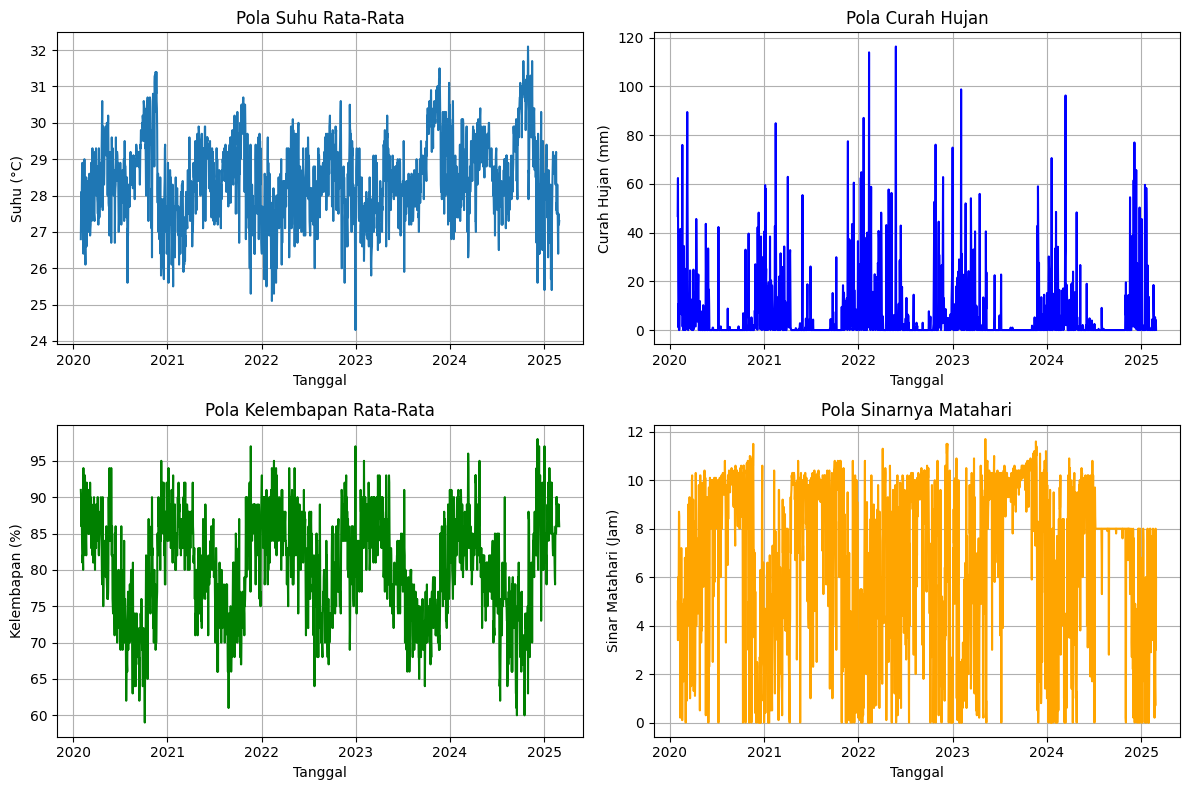

In [17]:
# Visualisasi Pola Cuaca
plt.figure(figsize=(12, 8))
# Suhu Rata-Rata
plt.subplot(2, 2, 1)
plt.plot(df['TANGGAL'], df['TAVG'], label='Suhu Rata-Rata')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.title('Pola Suhu Rata-Rata')
plt.grid(True)
# Curah Hujan
plt.subplot(2, 2, 2)
plt.plot(df['TANGGAL'], df['RR'], label='Curah Hujan', color='blue')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.title('Pola Curah Hujan')
plt.grid(True)
# Kelembapan Rata-Rata
plt.subplot(2, 2, 3)
plt.plot(df['TANGGAL'], df['RH_AVG'], label='Kelembapan Rata-Rata', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Kelembapan (%)')
plt.title('Pola Kelembapan Rata-Rata')
plt.grid(True)
# Sinarnya Matahari
plt.subplot(2, 2, 4)
plt.plot(df['TANGGAL'], df['SS'], label='Sinarnya Matahari', color='orange')
plt.xlabel('Tanggal')
plt.ylabel('Sinar Matahari (Jam)')
plt.title('Pola Sinarnya Matahari')
plt.grid(True)
# Tampilkan semua grafik
plt.tight_layout()
plt.show()

In [18]:
# Mengubah nama kolom sesuai dengan deskripsi yang lebih mudah dipahami
time_series_data = df.rename(columns={
    'TN': 'Suhu_Min',
    'TX': 'Suhu_Max',
    'RH_AVG': 'Kelembapan_Rata',
    'RR': 'Curah_Hujan',
    'SS': 'Sinar_Matahari',
    'FF_X': 'Kecepatan_Angin_Max',
    'FF_AVG': 'Kecepatan_Angin_Rata',
    'TAVG': 'Suhu_Rata_Rata',
    'TX_lag1': 'Suhu_Max_1HariSebelum',
    'TX_lag7': 'Suhu_Max_7HariSebelum',
    'TX_lag15': 'Suhu_Max_15HariSebelum',
    'TX_lag30': 'Suhu_Max_30HariSebelum',
    'TX_rolling3': 'Suhu_Max_Rolling3Hari',
    'TX_rolling7': 'Suhu_Max_Rolling7Hari',
    'TX_rolling14': 'Suhu_Max_Rolling14Hari',
    'TX_rolling30': 'Suhu_Max_Rolling30Hari',
    'TAVG_lag1': 'Suhu_Rata_1HariSebelum',
    'TAVG_lag7': 'Suhu_Rata_7HariSebelum',
    'TAVG_lag15': 'Suhu_Rata_15HariSebelum',
    'TAVG_lag30': 'Suhu_Rata_30HariSebelum',
    'TAVG_rolling3': 'Suhu_Rata_Rolling3Hari',
    'TAVG_rolling7': 'Suhu_Rata_Rolling7Hari',
    'TAVG_rolling15': 'Suhu_Rata_Rolling15Hari',
    'TAVG_rolling30': 'Suhu_Rata_Rolling30Hari',
    'RH_AVG_lag1': 'Kelembapan_1HariSebelum',
    'RH_AVG_lag7': 'Kelembapan_7HariSebelum',
    'RH_AVG_lag15': 'Kelembapan_15HariSebelum',
    'RH_AVG_lag30': 'Kelembapan_30HariSebelum',
    'RH_AVG_rolling3': 'Kelembapan_Rolling3Hari',
    'RH_AVG_rolling7': 'Kelembapan_Rolling7Hari',
    'RH_AVG_rolling15': 'Kelembapan_Rolling15Hari',
    'RH_AVG_rolling30': 'Kelembapan_Rolling30Hari',
    'RR_lag1': 'Hujan_1HariSebelum',
    'RR_lag7': 'Hujan_7HariSebelum',
    'RR_lag15': 'Hujan_15HariSebelum',
    'RR_lag30': 'Hujan_30HariSebelum',
    'RR_rolling3': 'Hujan_Rolling3Hari',
    'RR_rolling7': 'Hujan_Rolling7Hari',
    'RR_rolling15': 'Hujan_Rolling15Hari',
    'RR_rolling30': 'Hujan_Rolling30Hari',
    'SS_lag1': 'Matahari_1HariSebelum',
    'SS_lag7': 'Matahari_7HariSebelum',
    'SS_lag15': 'Matahari_15HariSebelum',
    'SS_lag30': 'Matahari_30HariSebelum',
    'SS_rolling3': 'Matahari_Rolling3Hari',
    'SS_rolling7': 'Matahari_Rolling7Hari',
    'SS_rolling15': 'Matahari_Rolling15Hari',
    'SS_rolling30': 'Matahari_Rolling30Hari',
})

In [19]:
print("\nData setelah transformasi:")
time_series_data.head()


Data setelah transformasi:


,TANGGAL,Suhu_Min,Suhu_Max,Suhu_Rata_Rata,Kelembapan_Rata,Curah_Hujan,Sinar_Matahari,Kecepatan_Angin_Max,Kecepatan_Angin_Rata,Hari,...,Hujan_Rolling15Hari,Hujan_Rolling30Hari,Matahari_1HariSebelum,Matahari_7HariSebelum,Matahari_15HariSebelum,Matahari_30HariSebelum,Matahari_Rolling3Hari,Matahari_Rolling7Hari,Matahari_Rolling15Hari,Matahari_Rolling30Hari
30,2020-01-31,24.2,32.0,26.8,91,46.8,5.0,7,2,4,...,8.300000,10.056667,9.8,1.1,9.9,3.4,7.800000,8.271429,7.260000,6.006667
31,2020-02-01,25.2,31.6,27.4,90,62.4,3.4,6,2,5,...,12.460000,11.723333,5.0,10.3,10.9,0.0,6.066667,7.285714,6.760000,6.120000
32,2020-02-02,24.4,32.0,28.1,86,19.2,6.0,7,2,6,...,13.740000,12.363333,3.4,8.9,7.7,8.3,4.800000,6.871429,6.646667,6.043333
33,2020-02-03,25.4,31.8,27.0,90,1.1,3.7,9,2,0,...,13.146667,12.386667,6.0,9.6,7.7,5.8,4.366667,6.028571,6.380000,5.973333
34,2020-02-04,25.4,32.4,28.2,86,10.8,6.3,5,1,1,...,13.520000,12.743333,3.7,5.7,5.0,2.1,5.333333,6.114286,6.466667,6.113333


In [20]:
fitur_dasar = [
    'Suhu_Rata_Rata',
    'Kelembapan_Rata',
    'Sinar_Matahari',
]

In [21]:
fitur_lag = [
    'Suhu_Rata_1HariSebelum', 'Kelembapan_1HariSebelum',
    'Hujan_1HariSebelum', 'Matahari_1HariSebelum'
]

In [22]:
fitur_rolling = [
    'Suhu_Rata_Rolling3Hari', 'Kelembapan_Rolling3Hari',
    'Hujan_Rolling3Hari', 'Matahari_Rolling3Hari'
]

In [23]:
fitur_waktu = ['Hari', 'Bulan', 'Hari_Bulan']

In [24]:
# Gabungkan semua fitur
fitur = fitur_dasar + fitur_lag + fitur_rolling + fitur_waktu
target = 'Curah_Hujan'

# Memisahkan fitur dan target
X = time_series_data[fitur]
y = time_series_data[target]

In [25]:
# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("jumlah data x train: ", X_train.shape)
print("jumlah data y train: ", y_train.shape)
print("jumlah data x test: ", X_test.shape)
print("jumlah data y test: ", y_test.shape)

jumlah data x train:  (1485, 14)
jumlah data y train:  (1485,)
jumlah data x test:  (372, 14)
jumlah data y test:  (372,)


In [26]:
# Memilih dan melatih model (Random Forest)
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [27]:
# Evaluasi Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf:.4f}")
print(f"Random Forest - MSE: {mse_rf:.4f}")
print(f"Random Forest - RMSE: {rmse_rf:.4f}")
print(f"Random Forest - R² Score: {r2_rf:.4f}")

Random Forest - MAE: 3.4433
Random Forest - MSE: 62.7942
Random Forest - RMSE: 7.9243
Random Forest - R² Score: 0.6028


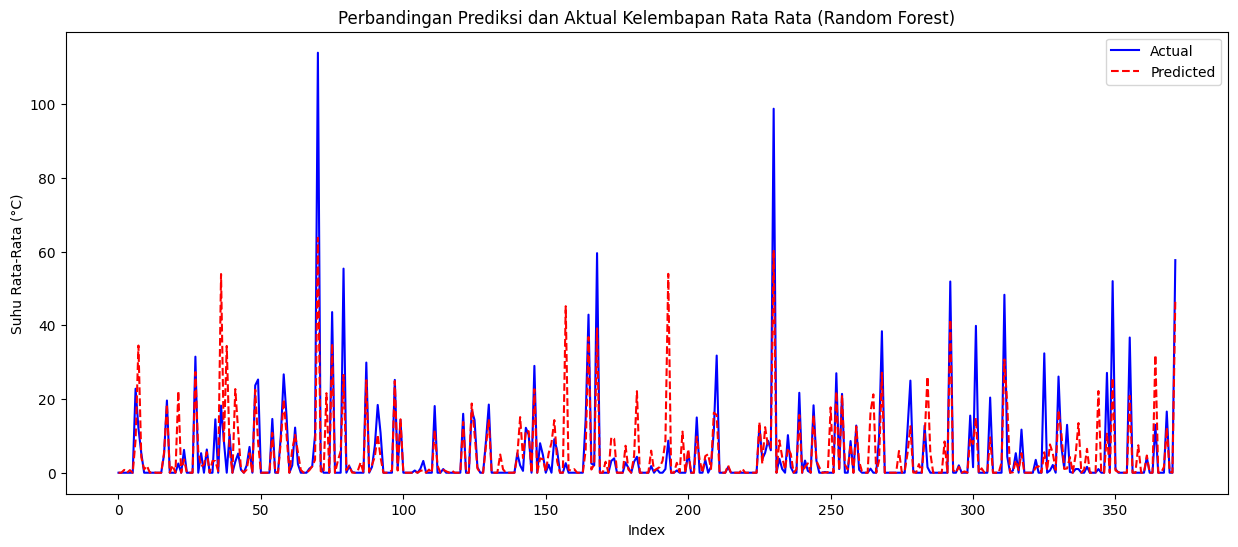

In [28]:
# Visualisasi hasil Random Forest
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_rf, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual Kelembapan Rata Rata (Random Forest)')
plt.legend()
plt.show()

In [29]:
# Membuat dan melatih model Gradient Boosting
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)

# Memprediksi menggunakan data pengujian
y_pred_gb = model_gb.predict(X_test)

In [30]:
# Evaluasi Gradient Boosting
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - MAE: {mae_gb:.4f}")
print(f"Gradient Boosting - MSE: {mse_gb:.4f}")
print(f"Gradient Boosting - RMSE: {rmse_gb:.4f}")
print(f"Gradient Boosting - R² Score: {r2_gb:.4f}")

Gradient Boosting - MAE: 3.9913
Gradient Boosting - MSE: 67.1912
Gradient Boosting - RMSE: 8.1970
Gradient Boosting - R² Score: 0.5750


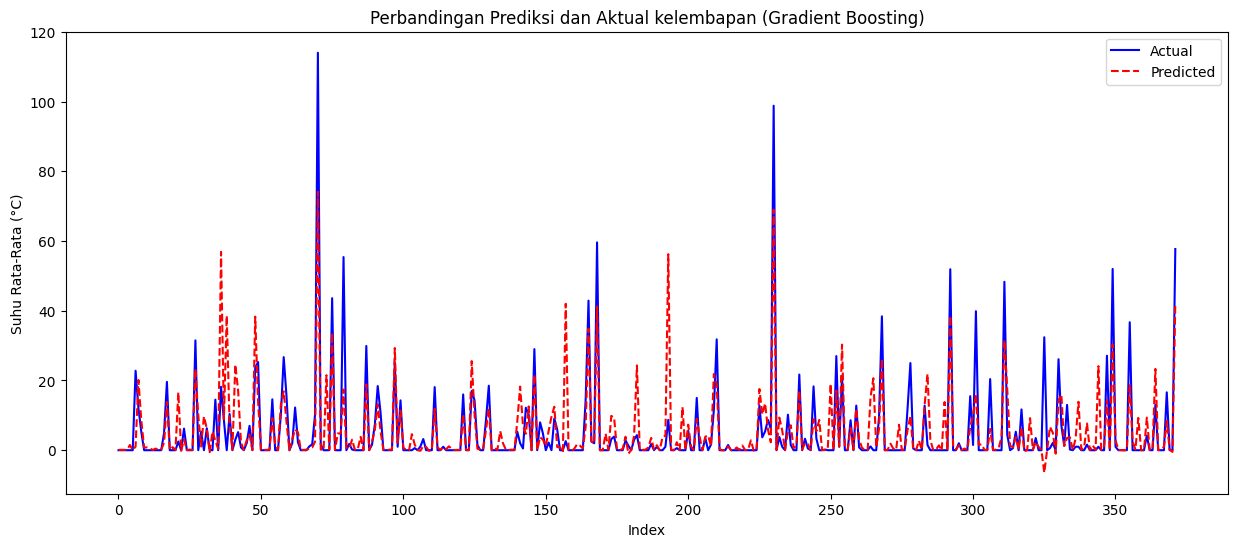

In [31]:
# Visualisasi hasil Gradient Boosting
plt.figure(figsize=(15, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_gb, label='Predicted', color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Suhu Rata-Rata (°C)')
plt.title('Perbandingan Prediksi dan Aktual kelembapan (Gradient Boosting)')
plt.legend()
plt.show()

In [32]:
# Buat model XGBoost Regressor
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train)
# Prediksi
y_pred_xgb = model_xgb.predict(X_test)

In [33]:
# Evaluasi XGBoost Regressor
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_gb = np.sqrt(mse_xgb)
r2_gb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_gb:.4f}")
print(f"XGBoost - MSE: {mse_gb:.4f}")
print(f"XGBoost - RMSE: {rmse_gb:.4f}")
print(f"XGBoost - R² Score: {r2_gb:.4f}")

XGBoost - MAE: 3.9913
XGBoost - MSE: 67.1912
XGBoost - RMSE: 8.3629
XGBoost - R² Score: 0.5576
